In [1]:
# ===== Mount Google Drive (Colab) =====
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# WITH CONTEXT

## Dataset Generation

In [2]:
# ============================================
# Perfect Model
# - Deterministic logic only (no noise)
# - Stimuli restricted to U/D/L/R
# - Vocab: U D L R A B C E 0 =>
# ============================================

# ===== Imports =====
import os, csv, random
import numpy as np
from tqdm import tqdm
import pandas as pd

# ===== Config =====
# I/O paths
LAYOUT_TXT  = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_layouts.txt"
OUT_DIR     = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf"
os.makedirs(OUT_DIR, exist_ok=True)

# Dataset parameters
NUM_TOTAL     = 10000       # number of sequences
VAL_RATIO     = 0.10        # 10% for validation
WINDOW_SIZE   = 4           # 4 trials -> 4*25 + '=>' + label
RNG_SEED      = 42          # reproducibility

# Vocabulary
# 8 extra tokens + placeholder + =>
# Only U/D/L/R are used as stimuli
VOCAB_TOKENS     = ['U','D','L','R','A','B','C','E']
DIRECTION_TOKENS = ['U','D','L','R']
PLACEHOLDER      = '0'
CONGRUENCY_RATIO = 0.5       # P(congruent) = 0.5

TOKENS = VOCAB_TOKENS + [PLACEHOLDER, '=>']
stoi = {tok:i for i,tok in enumerate(TOKENS)}
itos = {i:tok for tok,i in stoi.items()}

# ===== Seed =====
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# ===== Load symmetric layouts =====
SYMMETRIC_LAYOUTS = []
with open(LAYOUT_TXT, "r") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        pos = tuple(map(int, s.split(',')))
        assert len(pos) == 5, f"Layout length != 5: {pos}"
        assert len(set(pos)) == 5, f"Duplicate positions: {pos}"
        assert all(0 <= p < 25 for p in pos), f"Invalid position: {pos}"
        SYMMETRIC_LAYOUTS.append(pos)

print(f"Loaded {len(SYMMETRIC_LAYOUTS)} layouts from file")

# ===== Helpers =====
def generate_centric_matrix_trial(layout, congruent=True):
    """
    Create a 5x5 matrix (flattened to 25 tokens).
    - layout[2] is the target position
    - flankers occupy the other 4 positions
    - target/flankers restricted to U/D/L/R
    """
    mat = [PLACEHOLDER] * 25

    target_token = random.choice(DIRECTION_TOKENS)

    if congruent:
        flanker_token = target_token
    else:
        choices = [t for t in DIRECTION_TOKENS if t != target_token]
        flanker_token = random.choice(choices)

    for i, p in enumerate(layout):
        mat[p] = target_token if i == 2 else flanker_token
    return mat, target_token, congruent

def encode_sequence(trials, label_token):
    """
    Encode: 4 trials (4*25 tokens) + '=>' + label,
    mapped into token IDs.
    """
    seq = []
    for t in trials:
        seq.extend(t)
    seq.append('=>')
    seq.append(label_token)
    return [stoi[t] for t in seq]

# ===== Sequence generation =====
def generate_sequence_matrix(window_size=4):
    trials, layouts, flags, labels = [], [], [], []
    for _ in range(window_size):
        layout = random.choice(SYMMETRIC_LAYOUTS)
        is_cong = (random.random() < CONGRUENCY_RATIO)
        mat, tgt, flag = generate_centric_matrix_trial(layout, congruent=is_cong)
        # Perfect model: no corruption/noise
        trials.append(mat)
        layouts.append(layout)
        flags.append(flag)
        labels.append(tgt)
    return trials, labels[-1], layouts[-1], flags[-1]  # label/metadata from trial 4

def generate_matrix_dataset(num_sequences=10000, window_size=4):
    seqs, layout4, flags4 = [], [], []
    for _ in tqdm(range(num_sequences), desc="Generating Perfect sequences"):
        trials, label_tok, layout_last, cong_last = generate_sequence_matrix(window_size)
        token_ids = encode_sequence(trials, label_tok)
        seqs.append(token_ids)
        layout4.append(layout_last)
        flags4.append(cong_last)
    return seqs, layout4, flags4

print("Generating dataset ...")
all_sequences, all_layouts, all_congruents = generate_matrix_dataset(
    num_sequences=NUM_TOTAL,
    window_size=WINDOW_SIZE
)

# ===== Shuffle & split =====
N = len(all_sequences)
perm = np.random.RandomState(RNG_SEED).permutation(N)
all_sequences = [all_sequences[i] for i in perm]
all_layouts   = [all_layouts[i]   for i in perm]
all_congruents= [all_congruents[i]for i in perm]

split_idx = int(N * (1 - VAL_RATIO))
train_set, val_set = all_sequences[:split_idx], all_sequences[split_idx:]
train_layouts, val_layouts = all_layouts[:split_idx], all_layouts[split_idx:]
train_flags, val_flags     = all_congruents[:split_idx], all_congruents[split_idx:]

# ===== Save .npy =====
np.save(os.path.join(OUT_DIR, 'train.npy'), np.array(train_set, dtype=np.int32))
np.save(os.path.join(OUT_DIR, 'val.npy'),   np.array(val_set,   dtype=np.int32))
print(f"Saved .npy -> {OUT_DIR}")
print(f"train.npy: {len(train_set):,} | val.npy: {len(val_set):,}")

# ===== Save aligned meta =====
def layout_to_str(tup5):
    return "-".join(map(str, tup5))

train_meta = pd.DataFrame({
    "trial4_layout":   [layout_to_str(t) for t in train_layouts],
    "is_congruent":    [int(f) for f in train_flags],
    "seq_len":         [len(s) for s in train_set],
})
val_meta = pd.DataFrame({
    "trial4_layout":   [layout_to_str(t) for t in val_layouts],
    "is_congruent":    [int(f) for f in val_flags],
    "seq_len":         [len(s) for s in val_set],
})
train_meta.to_csv(os.path.join(OUT_DIR, "train_meta.csv"), index=False)
val_meta.to_csv(os.path.join(OUT_DIR, "val_meta.csv"), index=False)
print("Saved aligned meta CSV")

# ===== Save combined CSV (optional preview) =====
combined_csv = os.path.join(OUT_DIR, "flanker_matrix_perfect_pf_preview.csv")
with open(combined_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["trial_1_4_text", "target_response_token_id", "trial4_layout", "is_congruent"])
    for token_ids, layout, flag in zip(all_sequences, all_layouts, all_congruents):
        text = " ".join([itos[i] for i in token_ids[:-2]])
        target_id = token_ids[-1]
        layout_str = layout_to_str(layout)
        writer.writerow([text, target_id, layout_str, int(flag)])
print(f"Preview CSV saved: {combined_csv}")

# ===== Save vocab =====
with open(os.path.join(OUT_DIR, "vocab.txt"), "w") as f:
    f.write(",".join(TOKENS))
print("Saved vocab.txt")

# ===== Sanity check =====
print("\nSanity check:")
print(" - Example seq_len (should be 4*25+2 = 102):", val_meta["seq_len"].iloc[0] if len(val_meta) else "N/A")
print(" - Expected block_size for training:", "102-1 = 101")
print("\n✅ DONE.")

Loaded 128 layouts from file
Generating dataset ...


Generating Perfect sequences: 100%|██████████| 10000/10000 [00:00<00:00, 72929.07it/s]


Saved .npy -> /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf
train.npy: 9,000 | val.npy: 1,000
Saved aligned meta CSV
Preview CSV saved: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf/flanker_matrix_perfect_pf_preview.csv
Saved vocab.txt

Sanity check:
 - Example seq_len (should be 4*25+2 = 102): 102
 - Expected block_size for training: 102-1 = 101

✅ DONE.


## Training

In [3]:
# ============================================
# Train GPT-Flanker — Perfect Model (8 tokens)
# - Works for both context (seq_len=102) and no-context (seq_len=27)
# - Auto-detect block_size from dataset
# - Load vocab directly from dataset's vocab.txt
# ============================================

# ===== Imports =====
import os, sys
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

# Add path so Colab can locate model.py
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Flanker-GPT')
from model import GPT, GPTConfig

# ===== Paths (update as needed) =====
data_dir = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf"
out_dir  = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/checkpoints"
os.makedirs(out_dir, exist_ok=True)

# ===== Reproducibility =====
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ===== Load Dataset (.npy) =====
train_path = os.path.join(data_dir, 'train.npy')
val_path   = os.path.join(data_dir, 'val.npy')
assert os.path.exists(train_path) and os.path.exists(val_path), "train.npy/val.npy not found in data_dir"

train_data = np.load(train_path)
val_data   = np.load(val_path)

# Auto-detect sequence length & block_size
seq_len    = int(train_data.shape[1])     # includes label at the end
block_size = seq_len - 1                  # model input length (exclude label)
print(f"seq_len = {seq_len} -> block_size = {block_size}")

# ===== Load Vocab =====
vocab_txt = os.path.join(data_dir, "vocab.txt")
with open(vocab_txt, "r") as f:
    TOKENS = f.read().strip().split(",")
stoi = {tok: i for i, tok in enumerate(TOKENS)}
itos = {i: tok for tok, i in stoi.items()}
vocab_size = len(TOKENS)
print(f"Loaded vocab ({vocab_size} tokens): {TOKENS}")

# ===== Training Settings =====
device         = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size     = 64
max_iters      = 2000
eval_interval  = 200
learning_rate  = 3e-4
eval_batches   = 10  # batches used for quick loss estimate

# ===== Mini dataloader =====
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(len(data), size=batch_size)
    # x = all but last token, y = last token (label)
    x = torch.tensor(np.stack([d[:-1] for d in data[ix]]), dtype=torch.long, device=device)
    y = torch.tensor([d[-1] for d in data[ix]], dtype=torch.long, device=device)
    return x, y

# ===== Create Model =====
config = GPTConfig(
    vocab_size=vocab_size,
    block_size=block_size,
    n_layer=4,
    n_head=4,
    n_embd=128
)
model = GPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# ===== Eval helper =====
@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_batches)
        for k in range(eval_batches):
            X, Y = get_batch(split)
            logits, _ = model(X)
            logits = logits[:, -1, :]  # predict final position only
            loss = F.cross_entropy(logits, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

# ===== Training Loop =====
print("Training GPT-Flanker (Perfect Model, 8 tokens)...")
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, _ = model(xb)
    logits = logits[:, -1, :]         # predict only final token
    loss = F.cross_entropy(logits, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # Optional: gradient clipping to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

# ===== Save Model Checkpoint =====
# Name checkpoint clearly to indicate perfect + context/no-context
ckpt_name = "flanker_gpt_matrix_perfect_pf.pt"  # or "..._nocontext.pt"
ckpt_path = os.path.join(out_dir, ckpt_name)
torch.save(model.state_dict(), ckpt_path)
print(f"✅ Model saved to {ckpt_path}")

seq_len = 102 -> block_size = 101
Loaded vocab (10 tokens): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E', '0', '=>']
number of parameters: 0.79M
Training GPT-Flanker (Perfect Model, 8 tokens)...
Step 0: train loss 2.2846, val loss 2.2751
Step 200: train loss 0.0360, val loss 0.0356
Step 400: train loss 0.0053, val loss 0.0053
Step 600: train loss 0.0025, val loss 0.0025
Step 800: train loss 0.0015, val loss 0.0015
Step 1000: train loss 0.0010, val loss 0.0010
Step 1200: train loss 0.0007, val loss 0.0007
Step 1400: train loss 0.0005, val loss 0.0005
Step 1600: train loss 0.0004, val loss 0.0004
Step 1800: train loss 0.0003, val loss 0.0003
Step 1999: train loss 0.0003, val loss 0.0003
✅ Model saved to /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/checkpoints/flanker_gpt_matrix_perfect_pf.pt


## Evaluation

In [4]:
# ============================================
# Evaluate GPT-Flanker — Perfect Model (8 tokens)
# - Responses allowed: U/D/L/R/A/B/C/E
# - Loads vocab from dataset
# - Works for both context and no-context automatically
# ============================================

# ===== Imports =====
import os, sys, csv
import torch
import numpy as np
import torch.nn.functional as F
import pandas as pd

# ===== Add model path =====
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Flanker-GPT')
from model import GPT, GPTConfig

# ===== Settings =====
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Stopping-rule parameters
delta = 3
max_samples = 100
restrict_to_response_tokens = True  # restrict predictions to U/D/L/R/A/B/C/E

# ===== Paths (update as needed) =====
base_dir      = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT"
data_dir      = f"{base_dir}/flanker_matrix_dataset_perfect_pf"
ckpt_path     = f"{base_dir}/checkpoints/flanker_gpt_matrix_perfect_pf.pt"
val_path      = os.path.join(data_dir, "val.npy")
val_meta_path = os.path.join(data_dir, "val_meta.csv")
output_csv    = f"{base_dir}/gpt_perfect_pf_val_predictions_8resp_delta{delta}_max{max_samples}.csv"

# ===== Load Vocab =====
vocab_txt = os.path.join(data_dir, "vocab.txt")
assert os.path.exists(vocab_txt), f"vocab.txt not found: {vocab_txt}"
with open(vocab_txt, "r") as f:
    TOKENS = f.read().strip().split(",")

itos = {i: ch for i, ch in enumerate(TOKENS)}
stoi = {ch: i for i, ch in enumerate(TOKENS)}
vocab_size = len(TOKENS)

# Responses restricted to the 8 stimulus tokens
response_tokens = [t for t in TOKENS if t not in ['0','=>']]
response_token_ids = [stoi[t] for t in response_tokens]

print(f"Loaded vocab ({vocab_size}): {TOKENS}")
print(f"Response tokens used for prediction (8): {response_tokens}")

# ===== Load Validation Data =====
assert os.path.exists(val_path), f"val.npy not found: {val_path}"
val_data = np.load(val_path)
num_val = len(val_data)
block_size = val_data.shape[1] - 1
print(f"Loaded {num_val} validation samples | inferred block_size={block_size}")

# ===== Load aligned meta (val_meta.csv) =====
assert os.path.exists(val_meta_path), f"val_meta.csv not found: {val_meta_path}"
meta = pd.read_csv(val_meta_path)
assert len(meta) == num_val, f"val_meta rows ({len(meta)}) != VAL size ({num_val})"

# ===== Load Trained Model =====
config = GPTConfig(vocab_size=vocab_size, block_size=block_size, n_layer=4, n_head=4, n_embd=128)
model = GPT(config).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
print("✅ Loaded Perfect GPT Model")

# ===== Utils =====
def calculate_entropy(prob_dist_np):
    return -float(np.sum(prob_dist_np * np.log(prob_dist_np + 1e-12)))

def sample_until_threshold(probs_full, delta=3, max_samples=100, restrict_ids=None):
    """
    Sequential sampling until the gap between top and second counts >= delta.
    """
    if restrict_ids is not None:
        sub = probs_full[restrict_ids]
        sub = sub / sub.sum()
        id_map = restrict_ids
        def draw():
            return id_map[torch.multinomial(sub, num_samples=1, replacement=True).item()]
    else:
        def draw():
            return torch.multinomial(probs_full, num_samples=1, replacement=True).item()

    counts = {}
    for s in range(1, max_samples + 1):
        tok = draw()
        counts[tok] = counts.get(tok, 0) + 1
        sorted_pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
        top = sorted_pairs[0][1]
        second = sorted_pairs[1][1] if len(sorted_pairs) > 1 else 0
        gap = top - second
        if gap >= delta:
            return sorted_pairs[0][0], s, True, gap

    # fallback: argmax over restricted or full distribution
    if restrict_ids is not None:
        winner_id = restrict_ids[torch.argmax(probs_full[restrict_ids]).item()]
    else:
        winner_id = torch.argmax(probs_full).item()

    if counts:
        sorted_pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
        gap = sorted_pairs[0][1] - (sorted_pairs[1][1] if len(sorted_pairs) > 1 else 0)
    else:
        gap = 0
    return winner_id, max_samples, False, gap

# ===== Evaluation =====
results = []
correct = 0

for i in range(num_val):
    x = torch.tensor(val_data[i][:-1], dtype=torch.long, device=device).unsqueeze(0)
    true_id = int(val_data[i][-1])
    true_tok = itos[true_id]

    with torch.no_grad():
        logits, _ = model(x)
        probs = F.softmax(logits[:, -1, :], dim=-1).squeeze(0).cpu()

        winner_id, k_used, stopped, gap_at_stop = sample_until_threshold(
            probs_full=probs,
            delta=delta,
            max_samples=max_samples,
            restrict_ids=response_token_ids if restrict_to_response_tokens else None
        )

        pred_tok = itos[winner_id]
        is_correct = (winner_id == true_id)
        if is_correct:
            correct += 1

        confidence = float(probs[winner_id].item())
        prob_true  = float(probs[true_id].item())
        entropy    = calculate_entropy(probs.numpy())

    # aligned meta info
    is_congruent  = int(meta.loc[i, "is_congruent"])
    trial4_layout = meta.loc[i, "trial4_layout"]

    row = {
        "example": i + 1,
        "true_response": true_tok,
        "predicted_response": pred_tok,
        "is_correct": bool(is_correct),

        "confidence": round(confidence, 6),
        "prob_of_true_token": round(prob_true, 6),
        "entropy": round(entropy, 6),

        "k_samples": int(k_used),
        "stopped_by_delta": bool(stopped),
        "gap_at_stop": int(gap_at_stop),
        "delta": int(delta),
        "max_samples": int(max_samples),

        "is_congruent": is_congruent,
        "trial4_layout": trial4_layout,
    }

    # record probabilities for all vocab tokens
    for tok in TOKENS:
        row[f"{tok}_prob"] = round(float(probs[stoi[tok]].item()), 6)

    results.append(row)

# ===== Save Results =====
with open(output_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(results[0].keys()))
    writer.writeheader()
    writer.writerows(results)

acc = correct / num_val
print("\n✅ Stopping-rule evaluation complete.")
print(f"Accuracy = {acc * 100:.2f}% (Δ={delta}, max={max_samples})")
print(f"Saved to: {output_csv}")

Loaded vocab (10): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E', '0', '=>']
Response tokens used for prediction (8): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E']
Loaded 1000 validation samples | inferred block_size=101
number of parameters: 0.79M
✅ Loaded Perfect GPT Model

✅ Stopping-rule evaluation complete.
Accuracy = 100.00% (Δ=3, max=100)
Saved to: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100.csv


### Evaluation Analysis

In [5]:
import pandas as pd
import numpy as np

# ===== Path to evaluation results =====
csv_path = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100.csv"

df = pd.read_csv(csv_path)
print("Rows:", len(df))
print("Columns:", list(df.columns))

# ===== Check required columns =====
required = [
    "is_congruent", "k_samples", "stopped_by_delta", "gap_at_stop",
    "is_correct", "entropy", "confidence", "delta", "max_samples"
]
missing = [c for c in required if c not in df.columns]
print("Missing required columns:", missing)

# ===== Overall accuracy =====
acc_overall = df["is_correct"].mean()
print(f"\nAccuracy overall: {acc_overall*100:.2f}%")

# ===== Helper: summarize k_samples =====
def summarize_k(x):
    q = x.quantile([0, .25, .5, .75, .95, .99]).to_dict()
    return {
        "count": int(x.count()),
        "min": float(x.min()),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)),
        "p25": float(q[0.25]),
        "p50": float(q[0.5]),
        "p75": float(q[0.75]),
        "p95": float(q[0.95]),
        "p99": float(q[0.99]),
        "max": float(x.max()),
    }

# ===== k_samples summaries =====
print("\n== k_samples summary (overall) ==")
print(summarize_k(df["k_samples"]))

print("\n== k_samples summary by congruency ==")
for flag, g in df.groupby("is_congruent"):
    label = "congruent" if flag == 1 else "incongruent"
    print(f"\n[{label}] n={len(g)}")
    print("Accuracy:", round(g["is_correct"].mean()*100, 2), "%")
    print("Entropy mean:", round(g["entropy"].mean(), 4))
    print(summarize_k(g["k_samples"]))

# ===== Stopping diagnostics =====
stop_rate = df["stopped_by_delta"].mean()
hit_max = (df["k_samples"] >= df["max_samples"]).mean()
print(f"\nStopped by threshold (rate): {stop_rate*100:.2f}%")
print(f"Hit max_samples (rate): {hit_max*100:.2f}%")

# ===== Correlations =====
def safe_corr(a, b):
    if a.std(ddof=1) == 0 or b.std(ddof=1) == 0:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

corr_k_entropy = safe_corr(df["k_samples"], df["entropy"])
corr_k_one_minus_conf = safe_corr(df["k_samples"], 1 - df["confidence"])
print(f"\nCorr(k, entropy): {corr_k_entropy:.3f}")
print(f"Corr(k, 1-confidence): {corr_k_one_minus_conf:.3f}")

# ===== Predicted response distribution =====
if "predicted_response" in df.columns:
    print("\nPredicted response counts (top 10):")
    print(df["predicted_response"].value_counts().head(10))

# ===== Save a 100-row sample (for quick sharing/inspection) =====
sample_path = csv_path.replace(".csv", "_SAMPLE100.csv")
df.head(100).to_csv(sample_path, index=False)
print("\nSaved sample to:", sample_path)

Rows: 1000
Columns: ['example', 'true_response', 'predicted_response', 'is_correct', 'confidence', 'prob_of_true_token', 'entropy', 'k_samples', 'stopped_by_delta', 'gap_at_stop', 'delta', 'max_samples', 'is_congruent', 'trial4_layout', 'U_prob', 'D_prob', 'L_prob', 'R_prob', 'A_prob', 'B_prob', 'C_prob', 'E_prob', '0_prob', '=>_prob']
Missing required columns: []

Accuracy overall: 100.00%

== k_samples summary (overall) ==
{'count': 1000, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

== k_samples summary by congruency ==

[incongruent] n=477
Accuracy: 100.0 %
Entropy mean: 0.0031
{'count': 477, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

[congruent] n=523
Accuracy: 100.0 %
Entropy mean: 0.003
{'count': 523, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

Stopped by threshold (rate): 100.00%
Hit 

### Shared RT Parameters

In [6]:
### **You should run the evaluation to export files for all models first before running this cell**

# ===========================================
# Shared RT Parameters (Pooled)
# - Computes theta and dispersion from human RT and model k-samples
# - In-memory only (no saving to disk)
# ===========================================
import os
import numpy as np
import pandas as pd

# ---------- CONFIG ----------
HUMAN_META_TRAIN = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/human_dataset/train_meta.csv"
HUMAN_META_VAL   = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/human_dataset/val_meta.csv"

MODEL_PRED_FILES = [
    # context versions
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v1_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v2_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v3_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v4_val_predictions_stopping_delta3_max100.csv",

    # no-context versions
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v1_nocontext_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v2_nocontext_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v3_nocontext_val_predictions_stopping_delta3_max100.csv",
    "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_noisy_v4_nocontext_val_predictions_stopping_delta3_max100.csv",
]

# constants
t0 = 300.0                # ms (non-decision time)
TRIM_LO, TRIM_HI = 150, 3000   # human RT trimming range
DISPERSION_FALLBACK = 2.25     # fallback if estimation fails
DISPERSION_FILE_MASK = None    # optionally restrict dispersion calibration to subset of models


# ---------- Helpers ----------
def _maybe_trim(s, lo, hi):
    if lo is not None: s = s[s >= lo]
    if hi is not None: s = s[s <= hi]
    return s

def load_human_stats(train_meta_path, val_meta_path, t0, trim_lo=None, trim_hi=None):
    """Load and summarize human RT data."""
    meta = pd.concat([pd.read_csv(train_meta_path), pd.read_csv(val_meta_path)], ignore_index=True)
    assert {"trial4_response_time", "trial4_is_congruent"}.issubset(meta.columns), \
        "human meta must contain trial4_response_time and trial4_is_congruent"
    rt = meta["trial4_response_time"].dropna().astype(float)
    cong = meta.loc[rt.index, "trial4_is_congruent"].astype(int)
    rt = _maybe_trim(rt, trim_lo, trim_hi); cong = cong.loc[rt.index]
    p_con = float((cong == 1).mean()); p_inc = 1.0 - p_con
    mu_con = float(rt[cong == 1].mean()); mu_inc = float(rt[cong == 0].mean())
    mu_pool = p_con * mu_con + p_inc * mu_inc
    var_rt_minus_t0 = float((rt - t0).var(ddof=0))
    return dict(p_con=p_con, p_inc=p_inc, mu_con=mu_con, mu_inc=mu_inc,
                mu_pool=mu_pool, var_rt_minus_t0=var_rt_minus_t0,
                overall_mean=float(rt.mean()), overall_std=float(rt.std(ddof=0)), n_used=int(len(rt)))

def load_k_stats(pred_files, mask=None):
    """Load k_samples from prediction CSV files."""
    ks = []
    for fp in pred_files:
        bn = os.path.basename(fp)
        assert "SAMPLE" not in bn and "_RT_mapped_" not in bn, f"Do not use sample or RT-mapped files: {bn}"
        if mask is not None and not any(m.lower() in bn.lower() for m in mask):
            continue
        df = pd.read_csv(fp)
        assert "k_samples" in df.columns, f"{bn} does not contain column k_samples"
        ks.append(df["k_samples"].astype(float).values)
    if not ks:
        raise ValueError("No matching prediction files found")
    k_all = np.concatenate(ks, axis=0)
    return dict(k_mean=float(k_all.mean()), k_var=float(k_all.var(ddof=0)), n=int(k_all.size))

def theta_from(mu_pool_human, t0, k_mean_pool):
    """Compute shared theta from human mean RT and model mean k."""
    if k_mean_pool <= 0:
        raise ValueError("k_mean_pool must be > 0")
    return float((mu_pool_human - t0) / k_mean_pool)

def dispersion_from(var_rt_minus_t0, theta_shared, k_mean_pool, k_var_pool):
    """Compute dispersion parameter (>=1)."""
    # Var(RT - t0) = theta^2 * ( E[k]/disp + Var(k) )
    denom = (var_rt_minus_t0 / (theta_shared ** 2)) - k_var_pool
    if denom <= 0: return None
    return float(k_mean_pool / denom)


# ---------- Compute ----------
human = load_human_stats(HUMAN_META_TRAIN, HUMAN_META_VAL, t0, TRIM_LO, TRIM_HI)
k_all = load_k_stats(MODEL_PRED_FILES, mask=None)

theta_shared = theta_from(human["mu_pool"], t0, k_all["k_mean"])

if DISPERSION_FILE_MASK:
    k_for_disp = load_k_stats(MODEL_PRED_FILES, mask=DISPERSION_FILE_MASK)
else:
    k_for_disp = k_all

dispersion_shared = dispersion_from(human["var_rt_minus_t0"], theta_shared, k_for_disp["k_mean"], k_for_disp["k_var"])
dispersion_note = "pooled_estimated"
if dispersion_shared is None:
    dispersion_shared = float(DISPERSION_FALLBACK)
    dispersion_note = "used_fallback"

# ---------- Summary ----------
print("=== Shared RT Parameters (Plan B / pooled) ===")
print(f"t0 = {t0:.2f} ms")
print(f"theta_shared = {theta_shared:.4f} ms/sample")
print(f"dispersion_shared = {dispersion_shared:.4f}  ({dispersion_note})")
print("\n--- Human (trimmed) ---")
print(f"n = {human['n_used']:,}")
print(f"p_con = {human['p_con']:.4f} | p_inc = {human['p_inc']:.4f}")
print(f"mu_con = {human['mu_con']:.2f} ms | mu_inc = {human['mu_inc']:.2f} ms | mu_pool = {human['mu_pool']:.2f} ms")
print(f"overall_mean = {human['overall_mean']:.2f} | overall_std = {human['overall_std']:.2f}")
print(f"Var(RT - t0) = {human['var_rt_minus_t0']:.2f}")
print("\n--- k pooled (all models) ---")
print(f"k_mean = {k_all['k_mean']:.6f} | k_var = {k_all['k_var']:.6f} | n = {k_all['n']:,}")

# Final usable variables:
#   t0, theta_shared, dispersion_shared
#   human (dict), k_all (dict), k_for_disp (dict)

=== Shared RT Parameters (Plan B / pooled) ===
t0 = 300.00 ms
theta_shared = 150.9809 ms/sample
dispersion_shared = 2.2500  (used_fallback)

--- Human (trimmed) ---
n = 1,070,284
p_con = 0.5014 | p_inc = 0.4986
mu_con = 750.51 ms | mu_inc = 826.34 ms | mu_pool = 788.32 ms
overall_mean = 788.32 | overall_std = 204.96
Var(RT - t0) = 42008.21

--- k pooled (all models) ---
k_mean = 3.234300 | k_var = 2.528204 | n = 10,000


### RT Mapping (Shared Parameters)

In [7]:
# ===========================================
# RT Mapping with SHARED parameters (no per-condition fitting)
# - Uses pooled t0, theta_shared, dispersion_shared
# ===========================================
import pandas as pd
import numpy as np
import os

# ---------- INPUT ----------
in_csv = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100.csv"

# ---------- SHARED PARAMS (fixed across models & conditions) ----------
# If already defined upstream, reuse: t0, theta_shared, dispersion_shared
try:
    t0              # check if defined earlier
    theta_shared
    dispersion_shared
    dispersion = float(dispersion_shared)
except NameError:
    # Fallback fixed values (replace with your calibrated ones if available)
    t0 = 300.0               # non-decision time (ms)
    theta_shared = 151.0837  # ms per sample (from pooled Plan B)
    dispersion = 2.25        # controls variance (fallback or calibrated value)

t0_jitter_sd = 0.0           # optional Gaussian jitter on t0
use_erlang = True            # True = Gamma/Erlang RT, False = linear deterministic

# ---------- LOAD ----------
df = pd.read_csv(in_csv)
assert "k_samples" in df.columns, "CSV must contain column k_samples"

# ---------- MAP RT ----------
rng = np.random.default_rng(20250809)

def draw_rt_row(row):
    k = int(max(1, row["k_samples"]))
    t0_eff = t0 + (rng.normal(0, t0_jitter_sd) if t0_jitter_sd > 0 else 0.0)
    if not use_erlang:
        # Linear deterministic mapping
        return float(t0_eff + k * theta_shared)
    # Erlang/Gamma with dispersion control:
    # mean = k*theta_shared, var = theta_shared^2 * (k/dispersion)
    shape = k * dispersion
    scale = theta_shared / dispersion
    return float(t0_eff + rng.gamma(shape=shape, scale=scale))

df["rt_ms"] = df.apply(draw_rt_row, axis=1)

# Optional: clip to human RT reporting range
# df["rt_ms"] = df["rt_ms"].clip(150, 3000)

# ---------- SAVE ----------
suffix = "_RT_mapped_SHARED"
out_csv = os.path.splitext(in_csv)[0] + f"{suffix}.csv"
df.to_csv(out_csv, index=False)

# ---------- QUICK SUMMARY ----------
def summarize(s):
    d = s.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    return {k: float(d[k]) for k in d.index}

overall_pred = summarize(df["rt_ms"])

means_by_c = {}
gap_pred = float("nan")
if "is_congruent" in df.columns:
    means_by_c = df.groupby("is_congruent")["rt_ms"].mean().to_dict()
    gap_pred = means_by_c.get(0, np.nan) - means_by_c.get(1, np.nan)

print("\n=== Predicted RT (SHARED params) ===")
print(f"t0 = {t0:.1f} ms | theta_shared = {theta_shared:.4f} | dispersion = {dispersion:.4f}")
print("Overall:", overall_pred)
if means_by_c:
    print(f"Means by congruency: inc={means_by_c.get(0, np.nan):.2f} | con={means_by_c.get(1, np.nan):.2f} | gap={gap_pred:.2f} ms")
print("Saved:", out_csv)


=== Predicted RT (SHARED params) ===
t0 = 300.0 ms | theta_shared = 150.9809 | dispersion = 2.2500
Overall: {'count': 1000.0, 'mean': 757.2537972876182, 'std': 181.32421719860798, 'min': 387.41159962527684, '25%': 633.2860700455742, '50%': 727.4402436018165, '75%': 867.9155825259757, '90%': 986.4138658246454, '95%': 1074.2149834421537, '99%': 1305.0894139486202, 'max': 1735.1704025716751}
Means by congruency: inc=756.32 | con=758.10 | gap=-1.78 ms
Saved: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100_RT_mapped_SHARED.csv


### Congruency Effect Analysis

In [8]:
# ===========================================
# Analyze Congruency Effect — Perfect Model
# Requires: evaluation results (with stopping rule) + RT mapping (rt_ms column)
# ===========================================

from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ---------- INPUT ----------
base_dir = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT"
pred_csv = f"{base_dir}/gpt_perfect_pf_val_predictions_8resp_delta3_max100_RT_mapped_SHARED.csv"
out_dir  = os.path.join(base_dir, "congruency_effect_perfect")
os.makedirs(out_dir, exist_ok=True)

# Optional: human reference values for comparison
mu_con_human = 751.31
mu_inc_human = 825.40

# ---------- LOAD ----------
df = pd.read_csv(pred_csv)
req = {"is_congruent","rt_ms","is_correct","entropy","confidence","k_samples"}
missing = list(req - set(df.columns))
assert not missing, f"Missing columns: {missing}"

# ---------- BASIC SUMMARIES ----------
def summ(x: pd.Series):
    d = x.describe(percentiles=[.25,.5,.75,.9,.95,.99])
    return {k: float(d[k]) for k in d.index}

overall_rt = summ(df["rt_ms"])
by_c = df.groupby("is_congruent")["rt_ms"].mean().to_dict()
gap_ms = by_c.get(0, np.nan) - by_c.get(1, np.nan)

acc_overall = float(df["is_correct"].mean()*100)
acc_by_c = (df.groupby("is_congruent")["is_correct"]
              .mean()
              .rename({0:"incongruent",1:"congruent"})*100)

ent_by_c = df.groupby("is_congruent")["entropy"].mean().rename({0:"incongruent",1:"congruent"})
k_by_c   = df.groupby("is_congruent")["k_samples"].mean().rename({0:"incongruent",1:"congruent"})

def cohens_d(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if len(a)<2 or len(b)<2: return np.nan
    m1, m2 = a.mean(), b.mean()
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((len(a)-1)*s1*s1 + (len(b)-1)*s2*s2)/(len(a)+len(b)-2))
    return (m1-m2)/sp if sp>0 else np.nan

rt_inc = df.loc[df["is_congruent"]==0, "rt_ms"].values
rt_con = df.loc[df["is_congruent"]==1, "rt_ms"].values
d_eff  = cohens_d(rt_inc, rt_con)

print("=== Congruency Effect (Perfect Model) ===")
print("RT overall:", overall_rt)
print(f"RT means by congruency (ms): inc={by_c.get(0, np.nan):.2f} | con={by_c.get(1, np.nan):.2f} | gap={gap_ms:.2f}")
print(f"Cohen's d (inc - con): {d_eff:.3f}")
print(f"Accuracy overall: {acc_overall:.2f}% | by congruency (%):\n{acc_by_c.to_string()}")
print(f"Entropy mean by congruency:\n{ent_by_c.to_string()}")
print(f"k_samples mean by congruency:\n{k_by_c.to_string()}")

# ---------- Optional: compare with human ----------
print("\n--- vs Human targets (optional) ---")
human_gap = mu_inc_human - mu_con_human
print(f"Human means: con={mu_con_human:.2f} | inc={mu_inc_human:.2f} | gap={human_gap:.2f} ms")
print(f"Model deltas: Δcon={by_c.get(1, np.nan)-mu_con_human:.2f} | Δinc={by_c.get(0, np.nan)-mu_inc_human:.2f} | Δgap={gap_ms - human_gap:.2f} ms")

# ---------- SAVE TABLE ----------
rows = [
    {"metric":"RT_overall", **overall_rt},
    {"metric":"RT_mean_congruent", "mean": by_c.get(1, np.nan)},
    {"metric":"RT_mean_incongruent", "mean": by_c.get(0, np.nan)},
    {"metric":"RT_gap_inc_minus_con", "gap_ms": gap_ms},
    {"metric":"Cohens_d_inc_minus_con", "d": d_eff},
    {"metric":"Accuracy_overall_%", "value": acc_overall},
    {"metric":"Accuracy_congruent_%", "value": acc_by_c.get("congruent", np.nan)},
    {"metric":"Accuracy_incongruent_%", "value": acc_by_c.get("incongruent", np.nan)},
    {"metric":"Entropy_mean_congruent", "value": ent_by_c.get("congruent", np.nan)},
    {"metric":"Entropy_mean_incongruent", "value": ent_by_c.get("incongruent", np.nan)},
    {"metric":"k_mean_congruent", "value": k_by_c.get("congruent", np.nan)},
    {"metric":"k_mean_incongruent", "value": k_by_c.get("incongruent", np.nan)},
]
out_csv = os.path.join(out_dir, os.path.basename(pred_csv).replace(".csv","_congruency_stats.csv"))
pd.DataFrame(rows).to_csv(out_csv, index=False)

# ---------- PLOTS ----------
plt.figure(figsize=(6,4))
plt.hist(df.loc[df["is_congruent"]==1, "rt_ms"], bins=60, alpha=0.6, label="congruent")
plt.hist(df.loc[df["is_congruent"]==0, "rt_ms"], bins=60, alpha=0.6, label="incongruent")
plt.xlabel("RT (ms)"); plt.ylabel("Count"); plt.title("RT by Congruency (Histogram)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_hist_by_congruency.png"), dpi=160); plt.close()

def ecdf(x):
    xs = np.sort(x); ys = np.arange(1, len(xs)+1)/len(xs); return xs, ys
x1,y1 = ecdf(rt_con); x2,y2 = ecdf(rt_inc)
plt.figure(figsize=(6,4))
plt.plot(x1,y1,label="congruent"); plt.plot(x2,y2,label="incongruent")
plt.xlabel("RT (ms)"); plt.ylabel("CDF"); plt.title("RT CDF by Congruency")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_cdf_by_congruency.png"), dpi=160); plt.close()

plt.figure(figsize=(5,4))
plt.boxplot([rt_con, rt_inc], labels=["congruent","incongruent"])
plt.ylabel("RT (ms)"); plt.title("RT Boxplot by Congruency")
plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_box_by_congruency.png"), dpi=160); plt.close()

print("\nSaved:", out_csv)
print("Plots saved to:", out_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Congruency Effect (Perfect Model) ===
RT overall: {'count': 1000.0, 'mean': 757.2537972876182, 'std': 181.32421719860798, 'min': 387.4115996252768, '25%': 633.2860700455742, '50%': 727.4402436018165, '75%': 867.9155825259757, '90%': 986.4138658246454, '95%': 1074.2149834421537, '99%': 1305.08941394862, 'max': 1735.1704025716751}
RT means by congruency (ms): inc=756.32 | con=758.10 | gap=-1.78
Cohen's d (inc - con): -0.010
Accuracy overall: 100.00% | by congruency (%):
is_congruent
incongruent    100.0
congruent      100.0
Entropy mean by congruency:
is_congruent
incongruent    0.003058
congruent      0.003017
k_samples mean by congruency:
is_congruent
incongruent    3.0
congruent      3.0

--- vs Human targets (optional) ---
Human means: con=751.31 | inc=825.40 | gap=74.09 ms
Model deltas: Δcon=6.79 | Δinc=-69.08 | Δgap=-75.87 ms


/tmp/ipython-input-1915904000.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rt_con, rt_inc], labels=["congruent","incongruent"])



Saved: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/congruency_effect_perfect/gpt_perfect_pf_val_predictions_8resp_delta3_max100_RT_mapped_SHARED_congruency_stats.csv
Plots saved to: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/congruency_effect_perfect


# WITHOUT CONTEXT

## Dataset Generation

In [9]:
# ============================================
# Perfect Model
# - Deterministic logic only (no noise)
# - Stimuli restricted to U/D/L/R
# - Vocab: U D L R A B C E 0 =>
# ============================================

# ===== Imports =====
import os, csv, random
import numpy as np
from tqdm import tqdm
import pandas as pd

# ===== Config =====
# I/O paths
LAYOUT_TXT  = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_layouts.txt"
OUT_DIR     = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf_nocontext" #*
os.makedirs(OUT_DIR, exist_ok=True)

# Dataset parameters
NUM_TOTAL     = 10000       # number of sequences
VAL_RATIO     = 0.10        # 10% for validation
WINDOW_SIZE   = 1           # 1 trial -> 1*25 + '=>' + label #*
RNG_SEED      = 42          # reproducibility

# Vocabulary
# V4-compatible: 8 extra tokens + placeholder + =>
# Only U/D/L/R are used as stimuli
VOCAB_TOKENS     = ['U','D','L','R','A','B','C','E']
DIRECTION_TOKENS = ['U','D','L','R']
PLACEHOLDER      = '0'
CONGRUENCY_RATIO = 0.5       # P(congruent) = 0.5

TOKENS = VOCAB_TOKENS + [PLACEHOLDER, '=>']
stoi = {tok:i for i,tok in enumerate(TOKENS)}
itos = {i:tok for tok,i in stoi.items()}

# ===== Seed =====
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)

# ===== Load symmetric layouts =====
SYMMETRIC_LAYOUTS = []
with open(LAYOUT_TXT, "r") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        pos = tuple(map(int, s.split(',')))
        assert len(pos) == 5, f"Layout length != 5: {pos}"
        assert len(set(pos)) == 5, f"Duplicate positions: {pos}"
        assert all(0 <= p < 25 for p in pos), f"Invalid position: {pos}"
        SYMMETRIC_LAYOUTS.append(pos)

print(f"Loaded {len(SYMMETRIC_LAYOUTS)} layouts from file")

# ===== Helpers =====
def generate_centric_matrix_trial(layout, congruent=True):
    """
    Create a 5x5 matrix (flattened to 25 tokens).
    - layout[2] is the target position
    - flankers occupy the other 4 positions
    - target/flankers restricted to U/D/L/R
    """
    mat = [PLACEHOLDER] * 25

    target_token = random.choice(DIRECTION_TOKENS)

    if congruent:
        flanker_token = target_token
    else:
        choices = [t for t in DIRECTION_TOKENS if t != target_token]
        flanker_token = random.choice(choices)

    for i, p in enumerate(layout):
        mat[p] = target_token if i == 2 else flanker_token
    return mat, target_token, congruent

def encode_sequence(trials, label_token):
    """
    Encode: 4 trials (4*25 tokens) + '=>' + label,
    mapped into token IDs.
    """
    seq = []
    for t in trials:
        seq.extend(t)
    seq.append('=>')
    seq.append(label_token)
    return [stoi[t] for t in seq]

# ===== Sequence generation =====
def generate_sequence_matrix(window_size=4):
    trials, layouts, flags, labels = [], [], [], []
    for _ in range(window_size):
        layout = random.choice(SYMMETRIC_LAYOUTS)
        is_cong = (random.random() < CONGRUENCY_RATIO)
        mat, tgt, flag = generate_centric_matrix_trial(layout, congruent=is_cong)
        # Perfect model: no corruption/noise
        trials.append(mat)
        layouts.append(layout)
        flags.append(flag)
        labels.append(tgt)
    return trials, labels[-1], layouts[-1], flags[-1]  # label/metadata from trial 4

def generate_matrix_dataset(num_sequences=10000, window_size=4):
    seqs, layout4, flags4 = [], [], []
    for _ in tqdm(range(num_sequences), desc="Generating Perfect sequences"):
        trials, label_tok, layout_last, cong_last = generate_sequence_matrix(window_size)
        token_ids = encode_sequence(trials, label_tok)
        seqs.append(token_ids)
        layout4.append(layout_last)
        flags4.append(cong_last)
    return seqs, layout4, flags4

print("Generating dataset ...")
all_sequences, all_layouts, all_congruents = generate_matrix_dataset(
    num_sequences=NUM_TOTAL,
    window_size=WINDOW_SIZE
)

# ===== Shuffle & split =====
N = len(all_sequences)
perm = np.random.RandomState(RNG_SEED).permutation(N)
all_sequences = [all_sequences[i] for i in perm]
all_layouts   = [all_layouts[i]   for i in perm]
all_congruents= [all_congruents[i]for i in perm]

split_idx = int(N * (1 - VAL_RATIO))
train_set, val_set = all_sequences[:split_idx], all_sequences[split_idx:]
train_layouts, val_layouts = all_layouts[:split_idx], all_layouts[split_idx:]
train_flags, val_flags     = all_congruents[:split_idx], all_congruents[split_idx:]

# ===== Save .npy =====
np.save(os.path.join(OUT_DIR, 'train.npy'), np.array(train_set, dtype=np.int32))
np.save(os.path.join(OUT_DIR, 'val.npy'),   np.array(val_set,   dtype=np.int32))
print(f"Saved .npy -> {OUT_DIR}")
print(f"train.npy: {len(train_set):,} | val.npy: {len(val_set):,}")

# ===== Save aligned meta =====
def layout_to_str(tup5):
    return "-".join(map(str, tup5))

train_meta = pd.DataFrame({
    "trial4_layout":   [layout_to_str(t) for t in train_layouts],
    "is_congruent":    [int(f) for f in train_flags],
    "seq_len":         [len(s) for s in train_set],
})
val_meta = pd.DataFrame({
    "trial4_layout":   [layout_to_str(t) for t in val_layouts],
    "is_congruent":    [int(f) for f in val_flags],
    "seq_len":         [len(s) for s in val_set],
})
train_meta.to_csv(os.path.join(OUT_DIR, "train_meta.csv"), index=False)
val_meta.to_csv(os.path.join(OUT_DIR, "val_meta.csv"), index=False)
print("Saved aligned meta CSV")

# ===== Save combined CSV (optional preview) =====
combined_csv = os.path.join(OUT_DIR, "flanker_matrix_perfect_pf_nocontext_preview.csv") #*
with open(combined_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["trial_1_4_text", "target_response_token_id", "trial4_layout", "is_congruent"])
    for token_ids, layout, flag in zip(all_sequences, all_layouts, all_congruents):
        text = " ".join([itos[i] for i in token_ids[:-2]])
        target_id = token_ids[-1]
        layout_str = layout_to_str(layout)
        writer.writerow([text, target_id, layout_str, int(flag)])
print(f"Preview CSV saved: {combined_csv}")

# ===== Save vocab =====
with open(os.path.join(OUT_DIR, "vocab.txt"), "w") as f:
    f.write(",".join(TOKENS))
print("Saved vocab.txt")

# ===== Sanity check =====
print("\nSanity check:")
print(" - Example seq_len (should be 1*25+2 = 27):", val_meta["seq_len"].iloc[0] if len(val_meta) else "N/A") #*
print(" - Expected block_size for training:", "27-1 = 26") #*
print("\n✅ DONE.")

Loaded 128 layouts from file
Generating dataset ...


Generating Perfect sequences: 100%|██████████| 10000/10000 [00:00<00:00, 58576.64it/s]


Saved .npy -> /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf_nocontext
train.npy: 9,000 | val.npy: 1,000
Saved aligned meta CSV
Preview CSV saved: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf_nocontext/flanker_matrix_perfect_pf_nocontext_preview.csv
Saved vocab.txt

Sanity check:
 - Example seq_len (should be 1*25+2 = 27): 27
 - Expected block_size for training: 27-1 = 26

✅ DONE.


## Training

In [10]:
# ============================================
# Train GPT-Flanker — Perfect Model (8 tokens)
# - Works for both context (seq_len=102) and no-context (seq_len=27)
# - Auto-detect block_size from dataset
# - Load vocab directly from dataset's vocab.txt
# ============================================

# ===== Mount Google Drive =====
from google.colab import drive
drive.mount('/content/drive')

# ===== Imports =====
import os, sys
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

# Add path so Colab can locate model.py
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Flanker-GPT')
from model import GPT, GPTConfig

# ===== Paths (update as needed) =====
data_dir = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/flanker_matrix_dataset_perfect_pf_nocontext" #*
out_dir  = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/checkpoints"
os.makedirs(out_dir, exist_ok=True)

# ===== Reproducibility =====
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ===== Load Dataset (.npy) =====
train_path = os.path.join(data_dir, 'train.npy')
val_path   = os.path.join(data_dir, 'val.npy')
assert os.path.exists(train_path) and os.path.exists(val_path), "train.npy/val.npy not found in data_dir"

train_data = np.load(train_path)
val_data   = np.load(val_path)

# Auto-detect sequence length & block_size
seq_len    = int(train_data.shape[1])     # includes label at the end
block_size = seq_len - 1                  # model input length (exclude label)
print(f"seq_len = {seq_len} -> block_size = {block_size}")

# ===== Load Vocab =====
vocab_txt = os.path.join(data_dir, "vocab.txt")
with open(vocab_txt, "r") as f:
    TOKENS = f.read().strip().split(",")
stoi = {tok: i for i, tok in enumerate(TOKENS)}
itos = {i: tok for tok, i in stoi.items()}
vocab_size = len(TOKENS)
print(f"Loaded vocab ({vocab_size} tokens): {TOKENS}")

# ===== Training Settings =====
device         = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size     = 64
max_iters      = 2000
eval_interval  = 200
learning_rate  = 3e-4
eval_batches   = 10  # batches used for quick loss estimate

# ===== Mini dataloader =====
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(len(data), size=batch_size)
    # x = all but last token, y = last token (label)
    x = torch.tensor(np.stack([d[:-1] for d in data[ix]]), dtype=torch.long, device=device)
    y = torch.tensor([d[-1] for d in data[ix]], dtype=torch.long, device=device)
    return x, y

# ===== Create Model =====
config = GPTConfig(
    vocab_size=vocab_size,
    block_size=block_size,
    n_layer=4,
    n_head=4,
    n_embd=128
)
model = GPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# ===== Eval helper =====
@torch.no_grad()
def estimate_loss():
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_batches)
        for k in range(eval_batches):
            X, Y = get_batch(split)
            logits, _ = model(X)
            logits = logits[:, -1, :]  # predict final position only
            loss = F.cross_entropy(logits, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

# ===== Training Loop =====
print("Training GPT-Flanker (Perfect Model, 8 tokens)...")
for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')
    logits, _ = model(xb)
    logits = logits[:, -1, :]         # predict only final token
    loss = F.cross_entropy(logits, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    # Optional: gradient clipping to avoid exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

# ===== Save Model Checkpoint =====
# Name checkpoint clearly to indicate perfect + context/no-context
ckpt_name = "flanker_gpt_matrix_perfect_pf_nocontext.pt"  #*
ckpt_path = os.path.join(out_dir, ckpt_name)
torch.save(model.state_dict(), ckpt_path)
print(f"✅ Model saved to {ckpt_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
seq_len = 27 -> block_size = 26
Loaded vocab (10 tokens): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E', '0', '=>']
number of parameters: 0.79M
Training GPT-Flanker (Perfect Model, 8 tokens)...
Step 0: train loss 2.4496, val loss 2.4511
Step 200: train loss 0.0233, val loss 0.0218
Step 400: train loss 0.0036, val loss 0.0036
Step 600: train loss 0.0017, val loss 0.0017
Step 800: train loss 0.0010, val loss 0.0010
Step 1000: train loss 0.0007, val loss 0.0007
Step 1200: train loss 0.0005, val loss 0.0005
Step 1400: train loss 0.0004, val loss 0.0004
Step 1600: train loss 0.0003, val loss 0.0003
Step 1800: train loss 0.0002, val loss 0.0002
Step 1999: train loss 0.0002, val loss 0.0002
✅ Model saved to /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/checkpoints/flanker_gpt_matrix_perfect_pf_nocontext.pt


## Evaluation

In [11]:
# ============================================
# Evaluate GPT-Flanker — Perfect Model (8 tokens)
# - Responses allowed: U/D/L/R/A/B/C/E
# - Loads vocab from dataset
# - Works for both context and no-context automatically
# ============================================

# ===== Imports =====
import os, sys, csv
import torch
import numpy as np
import torch.nn.functional as F
import pandas as pd

# ===== Add model path =====
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Flanker-GPT')
from model import GPT, GPTConfig

# ===== Settings =====
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Stopping-rule parameters
delta = 3
max_samples = 100
restrict_to_response_tokens = True  # restrict predictions to U/D/L/R/A/B/C/E

# ===== Paths (update as needed) =====
base_dir      = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT"
data_dir      = f"{base_dir}/flanker_matrix_dataset_perfect_pf_nocontext" #*
ckpt_path     = f"{base_dir}/checkpoints/flanker_gpt_matrix_perfect_pf_nocontext.pt" #*
val_path      = os.path.join(data_dir, "val.npy")
val_meta_path = os.path.join(data_dir, "val_meta.csv")
output_csv    = f"{base_dir}/gpt_perfect_pf_nocontext_val_predictions_8resp_delta{delta}_max{max_samples}.csv" #*

# ===== Load Vocab =====
vocab_txt = os.path.join(data_dir, "vocab.txt")
assert os.path.exists(vocab_txt), f"vocab.txt not found: {vocab_txt}"
with open(vocab_txt, "r") as f:
    TOKENS = f.read().strip().split(",")

itos = {i: ch for i, ch in enumerate(TOKENS)}
stoi = {ch: i for i, ch in enumerate(TOKENS)}
vocab_size = len(TOKENS)

# Responses restricted to the 8 stimulus tokens
response_tokens = [t for t in TOKENS if t not in ['0','=>']]
response_token_ids = [stoi[t] for t in response_tokens]

print(f"Loaded vocab ({vocab_size}): {TOKENS}")
print(f"Response tokens used for prediction (8): {response_tokens}")

# ===== Load Validation Data =====
assert os.path.exists(val_path), f"val.npy not found: {val_path}"
val_data = np.load(val_path)
num_val = len(val_data)
block_size = val_data.shape[1] - 1
print(f"Loaded {num_val} validation samples | inferred block_size={block_size}")

# ===== Load aligned meta (val_meta.csv) =====
assert os.path.exists(val_meta_path), f"val_meta.csv not found: {val_meta_path}"
meta = pd.read_csv(val_meta_path)
assert len(meta) == num_val, f"val_meta rows ({len(meta)}) != VAL size ({num_val})"

# ===== Load Trained Model =====
config = GPTConfig(vocab_size=vocab_size, block_size=block_size, n_layer=4, n_head=4, n_embd=128)
model = GPT(config).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
print("✅ Loaded Perfect GPT Model")

# ===== Utils =====
def calculate_entropy(prob_dist_np):
    return -float(np.sum(prob_dist_np * np.log(prob_dist_np + 1e-12)))

def sample_until_threshold(probs_full, delta=3, max_samples=100, restrict_ids=None):
    """
    Sequential sampling until the gap between top and second counts >= delta.
    """
    if restrict_ids is not None:
        sub = probs_full[restrict_ids]
        sub = sub / sub.sum()
        id_map = restrict_ids
        def draw():
            return id_map[torch.multinomial(sub, num_samples=1, replacement=True).item()]
    else:
        def draw():
            return torch.multinomial(probs_full, num_samples=1, replacement=True).item()

    counts = {}
    for s in range(1, max_samples + 1):
        tok = draw()
        counts[tok] = counts.get(tok, 0) + 1
        sorted_pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
        top = sorted_pairs[0][1]
        second = sorted_pairs[1][1] if len(sorted_pairs) > 1 else 0
        gap = top - second
        if gap >= delta:
            return sorted_pairs[0][0], s, True, gap

    # fallback: argmax over restricted or full distribution
    if restrict_ids is not None:
        winner_id = restrict_ids[torch.argmax(probs_full[restrict_ids]).item()]
    else:
        winner_id = torch.argmax(probs_full).item()

    if counts:
        sorted_pairs = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
        gap = sorted_pairs[0][1] - (sorted_pairs[1][1] if len(sorted_pairs) > 1 else 0)
    else:
        gap = 0
    return winner_id, max_samples, False, gap

# ===== Evaluation =====
results = []
correct = 0

for i in range(num_val):
    x = torch.tensor(val_data[i][:-1], dtype=torch.long, device=device).unsqueeze(0)
    true_id = int(val_data[i][-1])
    true_tok = itos[true_id]

    with torch.no_grad():
        logits, _ = model(x)
        probs = F.softmax(logits[:, -1, :], dim=-1).squeeze(0).cpu()

        winner_id, k_used, stopped, gap_at_stop = sample_until_threshold(
            probs_full=probs,
            delta=delta,
            max_samples=max_samples,
            restrict_ids=response_token_ids if restrict_to_response_tokens else None
        )

        pred_tok = itos[winner_id]
        is_correct = (winner_id == true_id)
        if is_correct:
            correct += 1

        confidence = float(probs[winner_id].item())
        prob_true  = float(probs[true_id].item())
        entropy    = calculate_entropy(probs.numpy())

    # aligned meta info
    is_congruent  = int(meta.loc[i, "is_congruent"])
    trial4_layout = meta.loc[i, "trial4_layout"]

    row = {
        "example": i + 1,
        "true_response": true_tok,
        "predicted_response": pred_tok,
        "is_correct": bool(is_correct),

        "confidence": round(confidence, 6),
        "prob_of_true_token": round(prob_true, 6),
        "entropy": round(entropy, 6),

        "k_samples": int(k_used),
        "stopped_by_delta": bool(stopped),
        "gap_at_stop": int(gap_at_stop),
        "delta": int(delta),
        "max_samples": int(max_samples),

        "is_congruent": is_congruent,
        "trial4_layout": trial4_layout,
    }

    # record probabilities for all vocab tokens
    for tok in TOKENS:
        row[f"{tok}_prob"] = round(float(probs[stoi[tok]].item()), 6)

    results.append(row)

# ===== Save Results =====
with open(output_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(results[0].keys()))
    writer.writeheader()
    writer.writerows(results)

acc = correct / num_val
print("\n✅ Stopping-rule evaluation complete.")
print(f"Accuracy = {acc * 100:.2f}% (Δ={delta}, max={max_samples})")
print(f"Saved to: {output_csv}")

Loaded vocab (10): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E', '0', '=>']
Response tokens used for prediction (8): ['U', 'D', 'L', 'R', 'A', 'B', 'C', 'E']
Loaded 1000 validation samples | inferred block_size=26
number of parameters: 0.79M
✅ Loaded Perfect GPT Model

✅ Stopping-rule evaluation complete.
Accuracy = 100.00% (Δ=3, max=100)
Saved to: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100.csv


### Evaluation Analysis

In [12]:
import pandas as pd
import numpy as np

# ===== Path to evaluation results =====
csv_path = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100.csv" #*

df = pd.read_csv(csv_path)
print("Rows:", len(df))
print("Columns:", list(df.columns))

# ===== Check required columns =====
required = [
    "is_congruent", "k_samples", "stopped_by_delta", "gap_at_stop",
    "is_correct", "entropy", "confidence", "delta", "max_samples"
]
missing = [c for c in required if c not in df.columns]
print("Missing required columns:", missing)

# ===== Overall accuracy =====
acc_overall = df["is_correct"].mean()
print(f"\nAccuracy overall: {acc_overall*100:.2f}%")

# ===== Helper: summarize k_samples =====
def summarize_k(x):
    q = x.quantile([0, .25, .5, .75, .95, .99]).to_dict()
    return {
        "count": int(x.count()),
        "min": float(x.min()),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)),
        "p25": float(q[0.25]),
        "p50": float(q[0.5]),
        "p75": float(q[0.75]),
        "p95": float(q[0.95]),
        "p99": float(q[0.99]),
        "max": float(x.max()),
    }

# ===== k_samples summaries =====
print("\n== k_samples summary (overall) ==")
print(summarize_k(df["k_samples"]))

print("\n== k_samples summary by congruency ==")
for flag, g in df.groupby("is_congruent"):
    label = "congruent" if flag == 1 else "incongruent"
    print(f"\n[{label}] n={len(g)}")
    print("Accuracy:", round(g["is_correct"].mean()*100, 2), "%")
    print("Entropy mean:", round(g["entropy"].mean(), 4))
    print(summarize_k(g["k_samples"]))

# ===== Stopping diagnostics =====
stop_rate = df["stopped_by_delta"].mean()
hit_max = (df["k_samples"] >= df["max_samples"]).mean()
print(f"\nStopped by threshold (rate): {stop_rate*100:.2f}%")
print(f"Hit max_samples (rate): {hit_max*100:.2f}%")

# ===== Correlations =====
def safe_corr(a, b):
    if a.std(ddof=1) == 0 or b.std(ddof=1) == 0:
        return np.nan
    return float(np.corrcoef(a, b)[0, 1])

corr_k_entropy = safe_corr(df["k_samples"], df["entropy"])
corr_k_one_minus_conf = safe_corr(df["k_samples"], 1 - df["confidence"])
print(f"\nCorr(k, entropy): {corr_k_entropy:.3f}")
print(f"Corr(k, 1-confidence): {corr_k_one_minus_conf:.3f}")

# ===== Predicted response distribution =====
if "predicted_response" in df.columns:
    print("\nPredicted response counts (top 10):")
    print(df["predicted_response"].value_counts().head(10))

# ===== Save a 100-row sample (for quick sharing/inspection) =====
sample_path = csv_path.replace(".csv", "_SAMPLE100.csv")
df.head(100).to_csv(sample_path, index=False)
print("\nSaved sample to:", sample_path)

Rows: 1000
Columns: ['example', 'true_response', 'predicted_response', 'is_correct', 'confidence', 'prob_of_true_token', 'entropy', 'k_samples', 'stopped_by_delta', 'gap_at_stop', 'delta', 'max_samples', 'is_congruent', 'trial4_layout', 'U_prob', 'D_prob', 'L_prob', 'R_prob', 'A_prob', 'B_prob', 'C_prob', 'E_prob', '0_prob', '=>_prob']
Missing required columns: []

Accuracy overall: 100.00%

== k_samples summary (overall) ==
{'count': 1000, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

== k_samples summary by congruency ==

[incongruent] n=467
Accuracy: 100.0 %
Entropy mean: 0.0023
{'count': 467, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

[congruent] n=533
Accuracy: 100.0 %
Entropy mean: 0.0022
{'count': 533, 'min': 3.0, 'mean': 3.0, 'std': 0.0, 'p25': 3.0, 'p50': 3.0, 'p75': 3.0, 'p95': 3.0, 'p99': 3.0, 'max': 3.0}

Stopped by threshold (rate): 100.00%
Hit

### RT Mapping (Shared Parameters)

In [13]:
# ===========================================
# RT Mapping with SHARED parameters (no per-condition fitting)
# - Uses pooled t0, theta_shared, dispersion_shared
# ===========================================
import pandas as pd
import numpy as np
import os

# ---------- INPUT ----------
in_csv = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100.csv" #*

# ---------- SHARED PARAMS (fixed across models & conditions) ----------
# If already defined upstream, reuse: t0, theta_shared, dispersion_shared
try:
    t0              # check if defined earlier
    theta_shared
    dispersion_shared
    dispersion = float(dispersion_shared)
except NameError:
    # Fallback fixed values (replace with your calibrated ones if available)
    t0 = 300.0               # non-decision time (ms)
    theta_shared = 151.0837  # ms per sample (from pooled Plan B)
    dispersion = 2.25        # controls variance (fallback or calibrated value)

t0_jitter_sd = 0.0           # optional Gaussian jitter on t0
use_erlang = True            # True = Gamma/Erlang RT, False = linear deterministic

# ---------- LOAD ----------
df = pd.read_csv(in_csv)
assert "k_samples" in df.columns, "CSV must contain column k_samples"

# ---------- MAP RT ----------
rng = np.random.default_rng(20250809)

def draw_rt_row(row):
    k = int(max(1, row["k_samples"]))
    t0_eff = t0 + (rng.normal(0, t0_jitter_sd) if t0_jitter_sd > 0 else 0.0)
    if not use_erlang:
        # Linear deterministic mapping
        return float(t0_eff + k * theta_shared)
    # Erlang/Gamma with dispersion control:
    # mean = k*theta_shared, var = theta_shared^2 * (k/dispersion)
    shape = k * dispersion
    scale = theta_shared / dispersion
    return float(t0_eff + rng.gamma(shape=shape, scale=scale))

df["rt_ms"] = df.apply(draw_rt_row, axis=1)

# Optional: clip to human RT reporting range
# df["rt_ms"] = df["rt_ms"].clip(150, 3000)

# ---------- SAVE ----------
suffix = "RT_mapped_SHARED"
out_csv = os.path.splitext(in_csv)[0] + f"{suffix}.csv"
df.to_csv(out_csv, index=False)

# ---------- QUICK SUMMARY ----------
def summarize(s):
    d = s.describe(percentiles=[.25, .5, .75, .9, .95, .99])
    return {k: float(d[k]) for k in d.index}

overall_pred = summarize(df["rt_ms"])

means_by_c = {}
gap_pred = float("nan")
if "is_congruent" in df.columns:
    means_by_c = df.groupby("is_congruent")["rt_ms"].mean().to_dict()
    gap_pred = means_by_c.get(0, np.nan) - means_by_c.get(1, np.nan)

print("\n=== Predicted RT (SHARED params) ===")
print(f"t0 = {t0:.1f} ms | theta_shared = {theta_shared:.4f} | dispersion = {dispersion:.4f}")
print("Overall:", overall_pred)
if means_by_c:
    print(f"Means by congruency: inc={means_by_c.get(0, np.nan):.2f} | con={means_by_c.get(1, np.nan):.2f} | gap={gap_pred:.2f} ms")
print("Saved:", out_csv)


=== Predicted RT (SHARED params) ===
t0 = 300.0 ms | theta_shared = 150.9809 | dispersion = 2.2500
Overall: {'count': 1000.0, 'mean': 757.2537972876182, 'std': 181.32421719860798, 'min': 387.41159962527684, '25%': 633.2860700455742, '50%': 727.4402436018165, '75%': 867.9155825259757, '90%': 986.4138658246454, '95%': 1074.2149834421537, '99%': 1305.0894139486202, 'max': 1735.1704025716751}
Means by congruency: inc=751.99 | con=761.86 | gap=-9.87 ms
Saved: /content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100RT_mapped_SHARED.csv


### Congruency Effect Analysis

In [14]:
# ===========================================
# Analyze Congruency Effect — Perfect Model
# Requires: evaluation results (with stopping rule) + RT mapping (rt_ms column)
# ===========================================

from google.colab import drive
drive.mount('/content/drive')

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ---------- INPUT ----------
base_dir = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT"
pred_csv = f"{base_dir}/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100_RT_mapped_SHARED.csv" #*
out_dir  = os.path.join(base_dir, "congruency_effect_perfect_nocontext") #*
os.makedirs(out_dir, exist_ok=True)

# Optional: human reference values for comparison
mu_con_human = 751.31
mu_inc_human = 825.40

# ---------- LOAD ----------
df = pd.read_csv(pred_csv)
req = {"is_congruent","rt_ms","is_correct","entropy","confidence","k_samples"}
missing = list(req - set(df.columns))
assert not missing, f"Missing columns: {missing}"

# ---------- BASIC SUMMARIES ----------
def summ(x: pd.Series):
    d = x.describe(percentiles=[.25,.5,.75,.9,.95,.99])
    return {k: float(d[k]) for k in d.index}

overall_rt = summ(df["rt_ms"])
by_c = df.groupby("is_congruent")["rt_ms"].mean().to_dict()
gap_ms = by_c.get(0, np.nan) - by_c.get(1, np.nan)

acc_overall = float(df["is_correct"].mean()*100)
acc_by_c = (df.groupby("is_congruent")["is_correct"]
              .mean()
              .rename({0:"incongruent",1:"congruent"})*100)

ent_by_c = df.groupby("is_congruent")["entropy"].mean().rename({0:"incongruent",1:"congruent"})
k_by_c   = df.groupby("is_congruent")["k_samples"].mean().rename({0:"incongruent",1:"congruent"})

def cohens_d(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    if len(a)<2 or len(b)<2: return np.nan
    m1, m2 = a.mean(), b.mean()
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((len(a)-1)*s1*s1 + (len(b)-1)*s2*s2)/(len(a)+len(b)-2))
    return (m1-m2)/sp if sp>0 else np.nan

rt_inc = df.loc[df["is_congruent"]==0, "rt_ms"].values
rt_con = df.loc[df["is_congruent"]==1, "rt_ms"].values
d_eff  = cohens_d(rt_inc, rt_con)

print("=== Congruency Effect (Perfect Model) ===")
print("RT overall:", overall_rt)
print(f"RT means by congruency (ms): inc={by_c.get(0, np.nan):.2f} | con={by_c.get(1, np.nan):.2f} | gap={gap_ms:.2f}")
print(f"Cohen's d (inc - con): {d_eff:.3f}")
print(f"Accuracy overall: {acc_overall:.2f}% | by congruency (%):\n{acc_by_c.to_string()}")
print(f"Entropy mean by congruency:\n{ent_by_c.to_string()}")
print(f"k_samples mean by congruency:\n{k_by_c.to_string()}")

# ---------- Optional: compare with human ----------
print("\n--- vs Human targets (optional) ---")
human_gap = mu_inc_human - mu_con_human
print(f"Human means: con={mu_con_human:.2f} | inc={mu_inc_human:.2f} | gap={human_gap:.2f} ms")
print(f"Model deltas: Δcon={by_c.get(1, np.nan)-mu_con_human:.2f} | Δinc={by_c.get(0, np.nan)-mu_inc_human:.2f} | Δgap={gap_ms - human_gap:.2f} ms")

# ---------- SAVE TABLE ----------
rows = [
    {"metric":"RT_overall", **overall_rt},
    {"metric":"RT_mean_congruent", "mean": by_c.get(1, np.nan)},
    {"metric":"RT_mean_incongruent", "mean": by_c.get(0, np.nan)},
    {"metric":"RT_gap_inc_minus_con", "gap_ms": gap_ms},
    {"metric":"Cohens_d_inc_minus_con", "d": d_eff},
    {"metric":"Accuracy_overall_%", "value": acc_overall},
    {"metric":"Accuracy_congruent_%", "value": acc_by_c.get("congruent", np.nan)},
    {"metric":"Accuracy_incongruent_%", "value": acc_by_c.get("incongruent", np.nan)},
    {"metric":"Entropy_mean_congruent", "value": ent_by_c.get("congruent", np.nan)},
    {"metric":"Entropy_mean_incongruent", "value": ent_by_c.get("incongruent", np.nan)},
    {"metric":"k_mean_congruent", "value": k_by_c.get("congruent", np.nan)},
    {"metric":"k_mean_incongruent", "value": k_by_c.get("incongruent", np.nan)},
]
out_csv = os.path.join(out_dir, os.path.basename(pred_csv).replace(".csv","_congruency_stats.csv"))
pd.DataFrame(rows).to_csv(out_csv, index=False)

# ---------- PLOTS ----------
plt.figure(figsize=(6,4))
plt.hist(df.loc[df["is_congruent"]==1, "rt_ms"], bins=60, alpha=0.6, label="congruent")
plt.hist(df.loc[df["is_congruent"]==0, "rt_ms"], bins=60, alpha=0.6, label="incongruent")
plt.xlabel("RT (ms)"); plt.ylabel("Count"); plt.title("RT by Congruency (Histogram)")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_hist_by_congruency.png"), dpi=160); plt.close()

def ecdf(x):
    xs = np.sort(x); ys = np.arange(1, len(xs)+1)/len(xs); return xs, ys
x1,y1 = ecdf(rt_con); x2,y2 = ecdf(rt_inc)
plt.figure(figsize=(6,4))
plt.plot(x1,y1,label="congruent"); plt.plot(x2,y2,label="incongruent")
plt.xlabel("RT (ms)"); plt.ylabel("CDF"); plt.title("RT CDF by Congruency")
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_cdf_by_congruency.png"), dpi=160); plt.close()

plt.figure(figsize=(5,4))
plt.boxplot([rt_con, rt_inc], labels=["congruent","incongruent"])
plt.ylabel("RT (ms)"); plt.title("RT Boxplot by Congruency")
plt.tight_layout()
plt.savefig(os.path.join(out_dir,"rt_box_by_congruency.png"), dpi=160); plt.close()

print("\nSaved:", out_csv)
print("Plots saved to:", out_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
=== Congruency Effect (Perfect Model) ===
RT overall: {'count': 1000.0, 'mean': 757.5650371483999, 'std': 181.44763951779265, 'min': 387.4710982543958, '25%': 633.5129285444141, '50%': 727.7311902111182, '75%': 868.3021467664253, '90%': 986.8810885296402, '95%': 1074.7419699102616, '99%': 1305.7735501791472, 'max': 1736.1472828927226}
RT means by congruency (ms): inc=752.30 | con=762.18 | gap=-9.88
Cohen's d (inc - con): -0.054
Accuracy overall: 100.00% | by congruency (%):
is_congruent
incongruent    100.0
congruent      100.0
Entropy mean by congruency:
is_congruent
incongruent    0.002258
congruent      0.002220
k_samples mean by congruency:
is_congruent
incongruent    3.0
congruent      3.0

--- vs Human targets (optional) ---
Human means: con=751.31 | inc=825.40 | gap=74.09 ms
Model deltas: Δcon=10.87 | Δinc=-73.10 | Δgap=-83.97 ms

Saved: /content/drive

/tmp/ipython-input-2492017945.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rt_con, rt_inc], labels=["congruent","incongruent"])


# Erlang Distribution

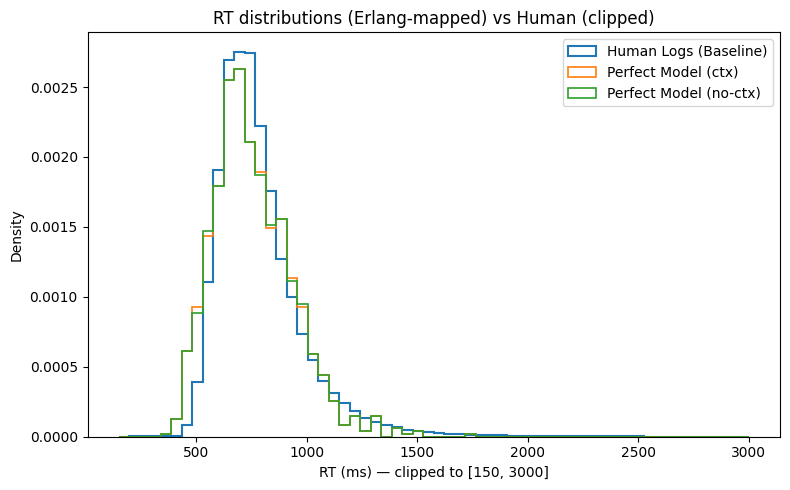

Quantiles (clipped):
Human Logs      : {'p10': 592.0, 'p50': 746.0, 'p90': 1027.0}
Perfect Model (ctx) : {'p10': 547.5711898900105, 'p50': 727.4402436018165, 'p90': 986.4138658246454}
Perfect Model (no-ctx): {'p10': 547.7397046691814, 'p50': 727.7311902111182, 'p90': 986.8810885296402}


In [15]:
# === RT distributions (clipped) — Human vs 1 Model (context & no-context) ===
# Provide paths for 3 inputs: human train/val meta, and 2 model CSVs (ctx & no-ctx)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- PATHS (fill in accordingly) ----------
HUMAN_META_TRAIN = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/human_dataset/train_meta.csv"   # << path to human train meta
HUMAN_META_VAL   = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/human_dataset/val_meta.csv"     # << path to human val meta

MODEL_CTX_CSV    = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_val_predictions_8resp_delta3_max100_RT_mapped_SHARED.csv"     # << path to model (context)
MODEL_NOCTX_CSV  = "/content/drive/MyDrive/Colab Notebooks/Flanker-GPT/gpt_perfect_pf_nocontext_val_predictions_8resp_delta3_max100_RT_mapped_SHARED.csv"  # << path to model (no-context)

CLIP_LO, CLIP_HI = 150, 3000  # clipping range (same as human baseline)

# ---------- helpers ----------
def clip_series(s, lo, hi):
    return s[(s >= lo) & (s <= hi)]

def load_human_rt(train_meta_path, val_meta_path, lo, hi):
    meta = pd.concat([pd.read_csv(train_meta_path), pd.read_csv(val_meta_path)], ignore_index=True)
    assert "trial4_response_time" in meta.columns, "Human meta must contain column: trial4_response_time"
    rt = meta["trial4_response_time"].dropna().astype(float)
    rt = clip_series(rt, lo, hi)
    return rt.values

def load_model_rt(csv_path, lo, hi):
    df = pd.read_csv(csv_path)
    assert "rt_ms" in df.columns, f"{csv_path} must contain column: rt_ms"
    rt = clip_series(df["rt_ms"].astype(float), lo, hi)
    return rt.values

# ---------- load ----------
human_rt  = load_human_rt(HUMAN_META_TRAIN, HUMAN_META_VAL, CLIP_LO, CLIP_HI)
model_ctx = load_model_rt(MODEL_CTX_CSV,   CLIP_LO, CLIP_HI)
model_nc  = load_model_rt(MODEL_NOCTX_CSV, CLIP_LO, CLIP_HI)

# ---------- plot (PDF via histogram density) ----------
plt.figure(figsize=(8,5))
plt.hist(human_rt,  bins=60, range=(CLIP_LO,CLIP_HI), density=True, histtype="step", linewidth=1.5, label="Human Logs (Baseline)")
plt.hist(model_ctx, bins=60, range=(CLIP_LO,CLIP_HI), density=True, histtype="step", linewidth=1.2, label="Perfect Model (ctx)")
plt.hist(model_nc,  bins=60, range=(CLIP_LO,CLIP_HI), density=True, histtype="step", linewidth=1.2, label="Perfect Model (no-ctx)")
plt.xlabel(f"RT (ms) — clipped to [{CLIP_LO}, {CLIP_HI}]")
plt.ylabel("Density")
plt.title("RT distributions (Erlang-mapped) vs Human (clipped)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- quick summary (quantiles) ----------
def qtxt(a):
    return dict(p10=float(np.percentile(a,10)), p50=float(np.percentile(a,50)), p90=float(np.percentile(a,90)))

print("Quantiles (clipped):")
print("Human Logs      :", qtxt(human_rt))
print("Perfect Model (ctx) :", qtxt(model_ctx))
print("Perfect Model (no-ctx):", qtxt(model_nc))